# Olfactory Bulb Interfrequency Partial Directed Coherence

In this preliminary analysis we will use *partial directed coherence* to look at the information flow between various frequency bands from an olfactory bulb recording.

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'image.cmap': 'jet'},style="whitegrid")

# Add python dir to path
import sys
sys.path.append('../python/')

import networkx as nx
from nxpd import nxpdParams, draw
nxpdParams['show'] = 'ipynb'


## Data Collection

5253


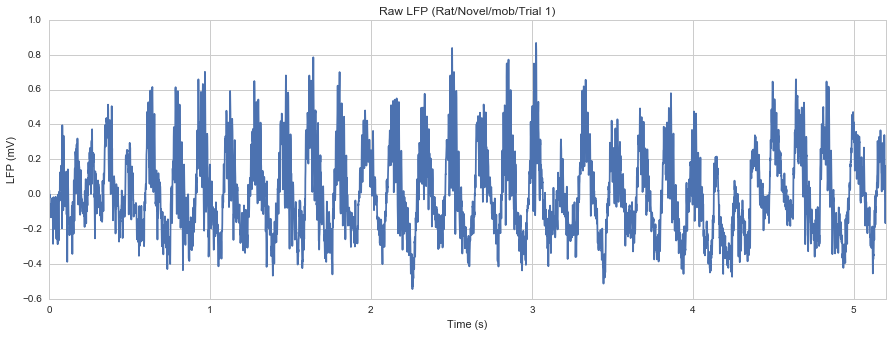

In [2]:
data = sio.loadmat('../data/Rat_170315.mat')['data']

# {Rat, Robot, Object, Grooming, Baseline}
type1 = 'Rat'
# {Novel, Familiar}
type2 = 'Novel'
# {mob, ca2, amyg}
region = 'mob'
# {1,...,<num_trials>}
trial = 1

if type1 in ('Rat','Robot','Object'):
    signal = data[type1][0,0][type2][0,0][region][0,0][trial][0]
else:
    signal = data[type1][0,0][region][0,0][trial][0]
    
# Define sample rate (Hz)
fs = 1010.10 
# Total number of samples
N = signal.size
# Time indices of samples
ns = np.linspace(0,N/fs,N)
# Reshape signal to be 1-D vector
signal = signal.reshape(N)

fig = plt.figure(figsize=(15,5))
plt.plot(ns,signal)
plt.title("Raw LFP (%s/%s/%s/Trial %i)"%(type1,type2,region,trial))
plt.xlabel('Time (s)')
plt.ylabel('LFP (mV)')
plt.xlim([0,N/fs]);
print(N)


## Extraction of Frequency Bands

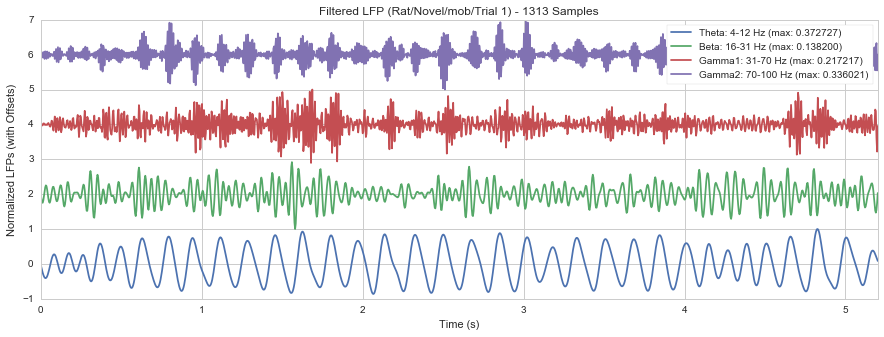

In [3]:
# Filtering function from supplementary python file
from preprocess import extract_freqs

# Define frequency bands in Hz (copied from Eric's ppt)
theta_band = [4.0,12.0]
beta_band = [16.0,31.0]
gamma_band1_low = [31.0,59.0] # Below 60 Hz Noise
gamma_band1_high = [61.0,70] # Above 60 Hz noise
gamma_band2 = [70.0,100.0]


# Decimate so that the model is simpler (dec_factor=1 leaves the same)
dec_factor = 4

# Filter for each band and normalize
[theta,beta,gamma2],[max_theta,max_beta,max_gamma2] = \
    extract_freqs(signal,[theta_band,beta_band,gamma_band2],fs,normalize=True,dec=dec_factor)
    
# Filter the 31-70Hz band without normalizing
[gamma1_low,gamma1_high],[_,_] = extract_freqs(signal,[gamma_band1_low,gamma_band1_high],fs,normalize=False,dec=dec_factor)
# Combine the below and above 60 Hz noise components of 31 - 70 Hz Gamma Band
gamma1 = gamma1_low + gamma1_high
# Normalize
max_gamma1 = np.amax(gamma1)
gamma1 = gamma1/max_gamma1

# Recreate time indices with correct number of points
ns = np.linspace(0,N/fs,len(theta))
    
fig = plt.figure(figsize=(15,5))
plt.plot(ns,theta,label='Theta: %d-%d Hz (max: %f)'%(theta_band[0],theta_band[1],max_theta))
plt.plot(ns,beta+2,label='Beta: %d-%d Hz (max: %f)'%(beta_band[0],beta_band[1],max_beta))
plt.plot(ns,gamma1+4,label='Gamma1: %d-%d Hz (max: %f)'%(gamma_band1_low[0],gamma_band1_high[1],max_gamma1))
plt.plot(ns,gamma2+6,label='Gamma2: %d-%d Hz (max: %f)'%(gamma_band2[0],gamma_band2[1],max_gamma2))
plt.title("Filtered LFP (%s/%s/%s/Trial %i) - %i Samples"%(type1,type2,region,trial,N/dec_factor))
plt.xlabel('Time (s)')
plt.ylabel('Normalized LFPs (with Offsets)')
plt.xlim([0,N/fs])
plt.legend(frameon=True);


## Estimation of PDC

To do...

Model order is: 2


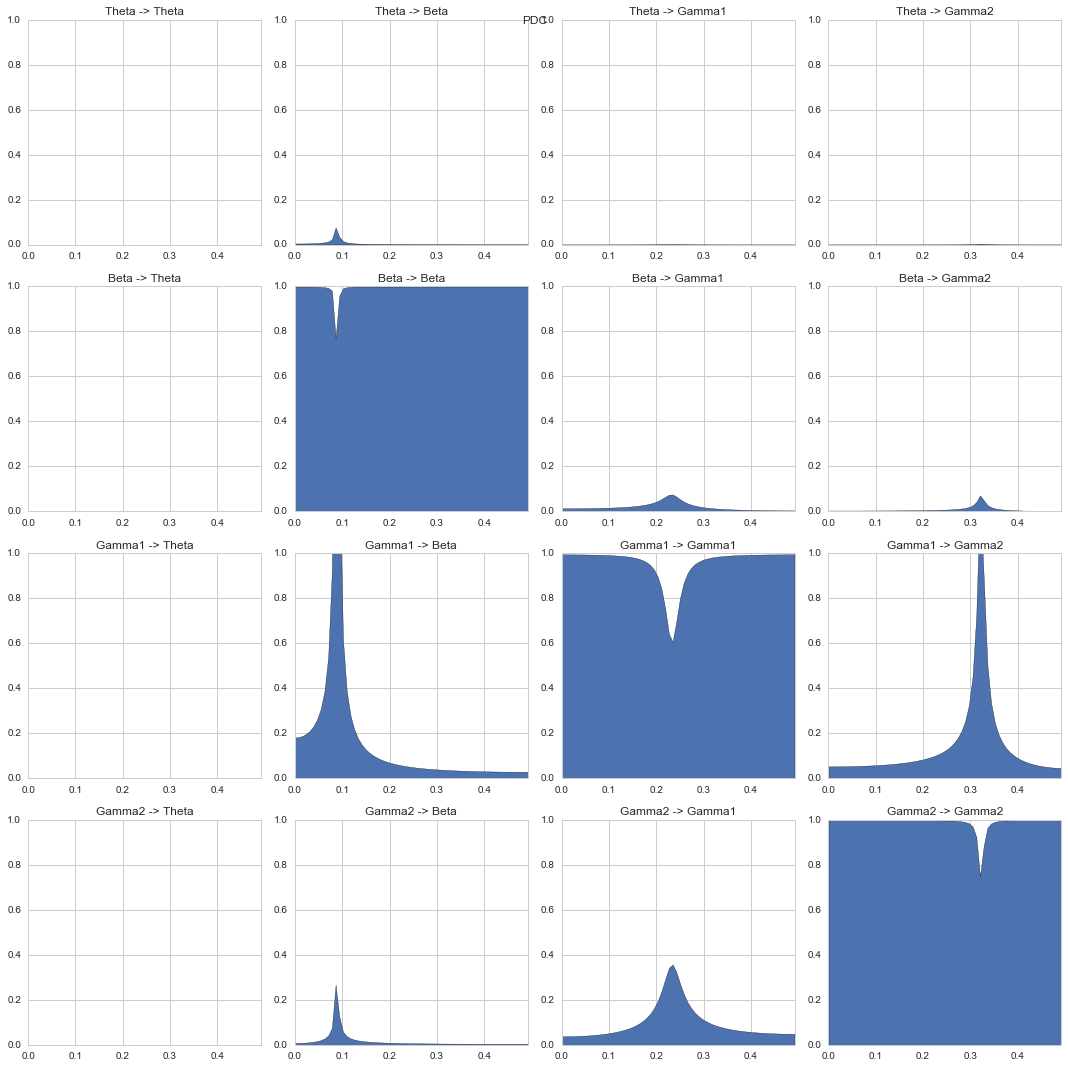

In [4]:
from pdc_dtf import mvar_fit, compute_order, PDC, plot_all

# Create matrix of time series
X = np.vstack((theta,beta,gamma1,gamma2))
# Compute AR order
model_order, bic = compute_order(X, p_max=50)
print("Model order is: %i"%model_order)
model, noise = mvar_fit(X,model_order)
pdc, freqs = PDC(model,np.diag(noise),n_fft=128)
plot_all(freqs,pdc,'PDC',labels=['Theta','Beta','Gamma1','Gamma2'])